In [27]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset,DataLoader

In [28]:
#set random seeds for reproducibility
torch.manual_seed(42)

In [29]:
#check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [30]:
df = pd.read_csv("../ANN/fmnist_small.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [31]:
df.shape

(6000, 785)

Data Visualization

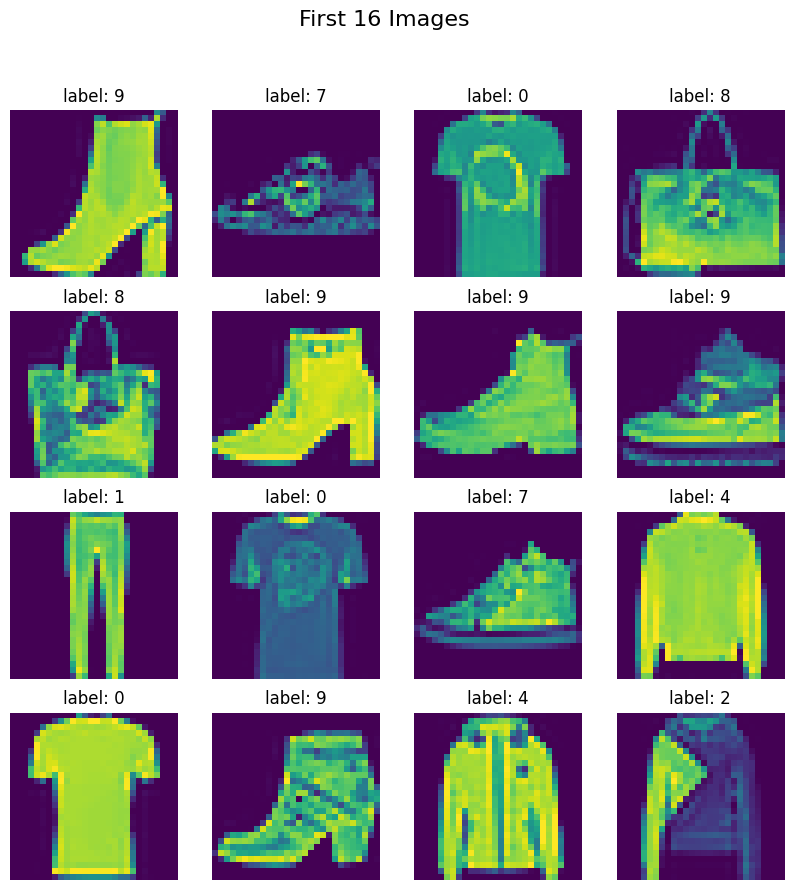

In [32]:
#create a 4*4 grid of images
fig,axes= plt.subplots(4,4,figsize=(10,10))  # gives matplotlib.figure type for the entire diagram and two dim(4,4) array of plts for each plt
fig.suptitle('First 16 Images',fontsize=16)  #gives title to the plot
#plt.subplots(4, 4) → Creates a grid of subplots, 4 rows and 4 columns (so 16 small plots total).
#figsize=(10, 10) → Sets the size of the entire figure to 10 inches by 10 inches.
#It returns:
#fig: the overall figure (the big canvas that holds all the small plots).
#axes: a 4x4 array (matrix) of individual Axes objects (each one is where you can plot things separately).
for i,ax in enumerate(axes.flat):    # axes.flat gives a 1d axis iterable so that we can access each axes in sequential manner
    #note axes.flat gives an iterator in 1d but .reshape(-1) would give new array 
    img = df.iloc[i,1:].values.reshape(28,28)   #reshape each row by converting series into numpy array
    ax.imshow(img) #display in that particular axes
    ax.axis('off') #remove axis for a cleaner look
    ax.set_title(f"label: {df.iloc[i,0]}")  #show the label in each title

Train test split

In [33]:
X = df.iloc[:,1:].values
y=df.iloc[:,0].values

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

each pixel consists value ranging from 0 to 255 so scale data

In [35]:
#scaling the features
X_train = X_train/255
X_test =X_test/255

# Create CustomDataset Class

In [36]:
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32)  #note in myNN for making weight matrix it by default makes it float32(single precision float) and we have float32(double precision float)
        #but nn layer only works if both are same so need to convert features in float32 
        #can also be done by .float()
        self.labels = torch.tensor(labels,dtype=torch.long)
        #for cross entropy loss it needs labels to be in int64 or long which is by default in labels case but 
        #we explicitly also implied torch.long for uniformity
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self,idx):
        return self.features[idx],self.labels[idx]
        

In [37]:
#instance of the class
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)


In [38]:
#create train and test loader
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True) #pin_memory = True for fast loading
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)



In [39]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [40]:
class MyNN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)  #softmax is implicitly present in pytorch cross entropy loss so no need to make it

        )

    def forward(self,features):
        return self.model(features)

In [41]:
#set learning rate and epochs
epochs = 100
lr = 0.1

In [42]:
#instantiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)

#loss function 
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(),lr=lr)


In [43]:
#training loop

for epoch in range(epochs):
    total_epoch_loss =0
    for batch_features,batch_labels in train_loader:
        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        #forward pass
        y_pred = model(batch_features)
        
        #loss 
        batch_loss = criterion(y_pred,batch_labels)

        optimizer.zero_grad()

        #backward pass
        batch_loss.backward()

        #parameters update
        optimizer.step()

        total_epoch_loss += batch_loss.item() #since batch_loss is a tensor total_epoch_loss in kept in the computational graph although final value is not changed. better to not keep epoch_loss in graph only attain scaler value of batch_loss by item()
    
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epochs: {epoch+1}, Loss: {avg_loss}')


        

Epochs: 1, Loss: 1.3216368559996288
Epochs: 2, Loss: 0.7793365331490835
Epochs: 3, Loss: 0.6427524622281392
Epochs: 4, Loss: 0.5751657448212306
Epochs: 5, Loss: 0.5278772489229838
Epochs: 6, Loss: 0.4953110001484553
Epochs: 7, Loss: 0.4619268426299095
Epochs: 8, Loss: 0.435526517033577
Epochs: 9, Loss: 0.4189064375559489
Epochs: 10, Loss: 0.39741520047187806
Epochs: 11, Loss: 0.3866572335362434
Epochs: 12, Loss: 0.3712778012951215
Epochs: 13, Loss: 0.3490207294623057
Epochs: 14, Loss: 0.34762983029087385
Epochs: 15, Loss: 0.3158551304042339
Epochs: 16, Loss: 0.3119578645626704
Epochs: 17, Loss: 0.29582368418574334
Epochs: 18, Loss: 0.2882651483019193
Epochs: 19, Loss: 0.2712535860141118
Epochs: 20, Loss: 0.2599384497354428
Epochs: 21, Loss: 0.2577110336224238
Epochs: 22, Loss: 0.24499942282835643
Epochs: 23, Loss: 0.23970586732029914
Epochs: 24, Loss: 0.22238561165829498
Epochs: 25, Loss: 0.22575185102721054
Epochs: 26, Loss: 0.2139669777949651
Epochs: 27, Loss: 0.21661923843125502
Epo

In [44]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [45]:
#evaluation code
correct =0

with torch.no_grad():
    for batch_features,batch_labels in test_loader:

        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        y_pred = model(batch_features) # in shape of [32(batch_size) , 10(classes)]

        #now extract labels for the final class
        _,y_pred = torch.max(y_pred,1)  #torch.max(tensor,1) gives the two tensors one of max values and other of indices of max_values in each row

        correct += (y_pred == batch_labels).sum().item()  #or (y_pred == batch_labels).float().sum().item()

    acc = correct /len(test_dataset)
    print("Accuracy :",acc)




Accuracy : 0.835


In whole data of fmnist accuracy increases to 89 % from 83 %

# if i run evaluation code for the training data 

In [46]:
#evaluation code
correct =0

with torch.no_grad():
    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        y_pred = model(batch_features) # in shape of [32(batch_size) , 10(classes)]

        #now extract labels for the final class
        _,y_pred = torch.max(y_pred,1)  #torch.max(tensor,1) gives the two tensors one of max values and other of indices of max_values in each row

        correct += (y_pred == batch_labels).sum().item()  #or (y_pred == batch_labels).float().sum().item()

    acc = correct /len(train_dataset)
    print("Accuracy :",acc)

Accuracy : 0.996875


we got 99 % accuracy so the model is obiously overfitting

Now lets apply solutions


1) Dropout
2) Regularization
3) Batch Normalization

In [21]:
class MyNN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,10)  #softmax is implicitly present in pytorch cross entropy loss so no need to make it

        )

    def forward(self,features):
        return self.model(features)

In [22]:
#instantiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)

#loss function 
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(),lr=lr,weight_decay=1e-4)

In [23]:
#training loop

for epoch in range(epochs):
    total_epoch_loss =0
    for batch_features,batch_labels in train_loader:
        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        #forward pass
        y_pred = model(batch_features)
        
        #loss 
        batch_loss = criterion(y_pred,batch_labels)

        optimizer.zero_grad()

        #backward pass
        batch_loss.backward()

        #parameters update
        optimizer.step()

        total_epoch_loss += batch_loss.item() #since batch_loss is a tensor total_epoch_loss in kept in the computational graph although final value is not changed. better to not keep epoch_loss in graph only attain scaler value of batch_loss by item()
    
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epochs: {epoch+1}, Loss: {avg_loss}')


        

Epochs: 1, Loss: 0.9732997937997182
Epochs: 2, Loss: 0.6825804338852565
Epochs: 3, Loss: 0.6201567920049031
Epochs: 4, Loss: 0.5779790562391282
Epochs: 5, Loss: 0.5303478315472603
Epochs: 6, Loss: 0.5128571995099386
Epochs: 7, Loss: 0.4880304444829623
Epochs: 8, Loss: 0.4750880780816078
Epochs: 9, Loss: 0.4327940289179484
Epochs: 10, Loss: 0.428858980735143
Epochs: 11, Loss: 0.40901841868956884
Epochs: 12, Loss: 0.39902385661999384
Epochs: 13, Loss: 0.4038383276263873
Epochs: 14, Loss: 0.3741888653238614
Epochs: 15, Loss: 0.3661976337432861
Epochs: 16, Loss: 0.34297151436408363
Epochs: 17, Loss: 0.3372239352265994
Epochs: 18, Loss: 0.3432354122896989
Epochs: 19, Loss: 0.3291302696367105
Epochs: 20, Loss: 0.3168558859825134
Epochs: 21, Loss: 0.3247401491800944
Epochs: 22, Loss: 0.31280566230416296
Epochs: 23, Loss: 0.29136114185055095
Epochs: 24, Loss: 0.29604196031888325
Epochs: 25, Loss: 0.29627899746100106
Epochs: 26, Loss: 0.27092343067129454
Epochs: 27, Loss: 0.2859306567410628
Epo

In [24]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
#evaluation code
correct =0

with torch.no_grad():
    for batch_features,batch_labels in test_loader:

        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        y_pred = model(batch_features) # in shape of [32(batch_size) , 10(classes)]

        #now extract labels for the final class
        _,y_pred = torch.max(y_pred,1)  #torch.max(tensor,1) gives the two tensors one of max values and other of indices of max_values in each row

        correct += (y_pred == batch_labels).sum().item()  #or (y_pred == batch_labels).float().sum().item()

    acc = correct /len(test_dataset)
    print("Accuracy :",acc)




Accuracy : 0.8433333333333334


In [26]:
#evaluation code
correct =0

with torch.no_grad():
    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        y_pred = model(batch_features) # in shape of [32(batch_size) , 10(classes)]

        #now extract labels for the final class
        _,y_pred = torch.max(y_pred,1)  #torch.max(tensor,1) gives the two tensors one of max values and other of indices of max_values in each row

        correct += (y_pred == batch_labels).sum().item()  #or (y_pred == batch_labels).float().sum().item()

    acc = correct /len(train_dataset)
    print("Accuracy :",acc)

Accuracy : 0.986875
